## Project Overview

Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. If homes can be found for them, many precious lives can be saved — and more happy families created.

In this Project i will uncover the Secrets behind pet adoption.

### Project Goals

* Extract insights about what makes pets more likely adopted.
* Build a model that will predict adoption speed for pets 
* Perform some data cleaning, try out multiple ML models.


In [1]:
import pandas as pd   
import numpy as np
import seaborn as sns
import pandas.util.testing as tm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
%matplotlib inline

from sklearn.metrics import cohen_kappa_score,make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_validate,RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from prettytable import PrettyTable

SEED = 42
sns.set()

import warnings
warnings.filterwarnings('ignore')

/var/folders/sf/jsnvw4tn5bd5khnq5nncxv940000gn/T/ipykernel_16028/2953300604.py:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
breeds = pd.read_csv('data/breed_labels.csv')
color = pd.read_csv('data/color_labels.csv')
state = pd.read_csv('data/state_labels.csv')

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test/test.csv')
sub = pd.read_csv('data/test/sample_submission.csv')

In [3]:
# main_count = df_train['AdoptionSpeed'].value_counts(normalize=True).sort_index()
df_train = train.copy()
def rename_values(df):
    df["Type"] = df["Type"].replace({1: "Dog", 2: "Cat"})
    df["Health"] = df["Health"].replace({1: "Healthy", 2: "Minor injury",
                            3:"Serious injury", 0:"Not specified"})
    df["Vaccinated"] = df["Vaccinated"].replace({1: "Yes", 2: "No",
                            3:"Not sure"})
    df["Gender"] = df["Gender"].replace({1: "Male", 2: "Female",
                            3:"Mixed"})
    df["Color1"] = df["Color1"].replace({1: "Black", 2: "Brown",
                            3:"Golden", 4:"Yellow", 5:"Cream", 6: "Gray", 7:"White"})
    df["Color2"] = df["Color2"].replace({1: "Black", 2: "Brown",
                            3:"Golden", 4:"Yellow", 5:"Cream", 6: "Gray", 7:"White"})
    df["MaturitySize"] = df["MaturitySize"].replace({1: "Small", 2: "Medium",
                            3:"Large", 4:"X-Large", 0:"Not specified"}) 
    df["FurLength"] = df["FurLength"].replace({1: "Short", 2: "Medium",
                            3:"Long",0:"Not specified"}) 
    df["Dewormed"] = df["Dewormed"].replace({1: "Yes", 2: "No",
                            3:"Not sure"})
    df["Sterilized"] = df["Sterilized"].replace({1: "Yes", 2: "No",
                            3:"Not sure"})
        
def plot(label):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x="AdoptionSpeed", hue=label, data=df_train)
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        ax.annotate('{:.2g}%'.format(100.*y/len(df_train)), (x.mean(), y), ha='center', va='bottom')
        ax.set_xticklabels(['Same day','1-7 days','8-30 days','31-90 days','> 100 days'])

rename_values(df_train)
rename_values(test)

#Create a new column called pure breed
df_train['pure_breed']= df_train['Breed2'].apply(lambda x: True if (x == 0) else False)
test['pure_breed']= test['Breed2'].apply(lambda x: True if (x == 0) else False)
# Create a new column for mixed color
df_train['mixed_color']= df_train['Color2'].apply(lambda x: False if (x == 0) else True)
test['mixed_color']= test['Color2'].apply(lambda x: False if (x == 0) else True)

# Exploratory Data Analysis

In [4]:
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


* There are 14993 datapoints in the dataset with 2 types of animals. Dogs and cats
* The train dataset contains informations such as age, breed, color, health status etc.
* The data contains description of the animal that can be used for textual analysis.
* The data has images and videos that we can use.
* The dataset contains data for states, color and breeds.

### Target: Adoption Speed
* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

#### Which pet types are the most strayed?

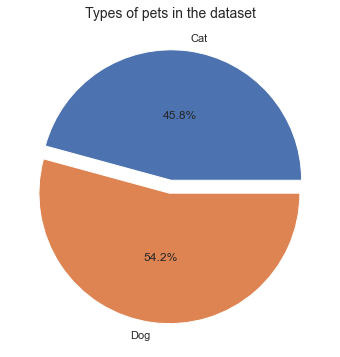

In [5]:
pet_type = df_train.groupby("Type").count()
pie, ax = plt.subplots(figsize=[6,6])
labels = pet_type["Breed1"].keys()
plt.pie(x=pet_type["Breed1"], autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Types of pets in the dataset", fontsize=14);

#### Adoption speed counts?

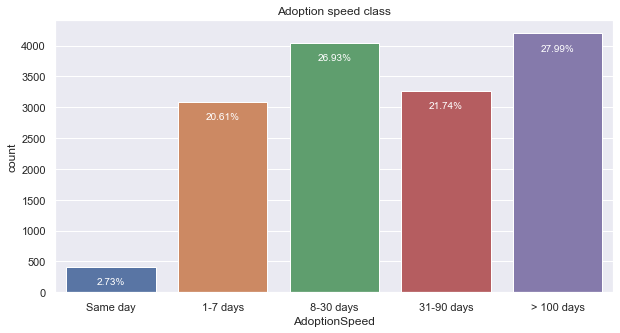

In [6]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df_train, x='AdoptionSpeed')
plt.title('Adoption speed class');
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()*100/df_train.shape[0]:.2f}%',(p.get_x()+p.get_width()/2., 
                                                                  p.get_height()), ha='center', va='top', color='white', size=10)
    ax.set_xticklabels(['Same day','1-7 days','8-30 days','31-90 days','> 100 days'])
plt.show()

20.61% of the pets are adopted in the first week of being listed by the shelter while 2.73% were adopted same day.

#### Adoption speed counts by type?

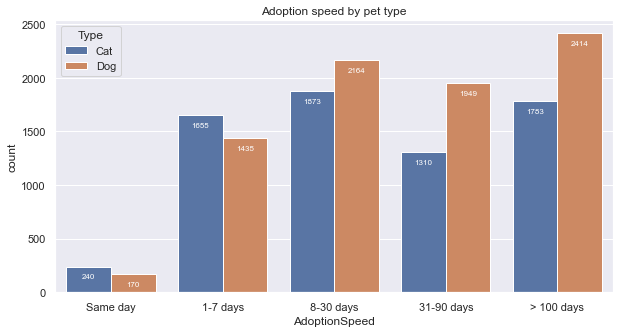

In [7]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df_train, x='AdoptionSpeed', hue='Type')
plt.title('Adoption speed by pet type');
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
    ax.set_xticklabels(['Same day','1-7 days','8-30 days','31-90 days','> 100 days'])
plt.show()

Cats are adopted faster than dogs for the first seven days at least compared to dogs. On the other hand, dogs are adopted faster after several months.

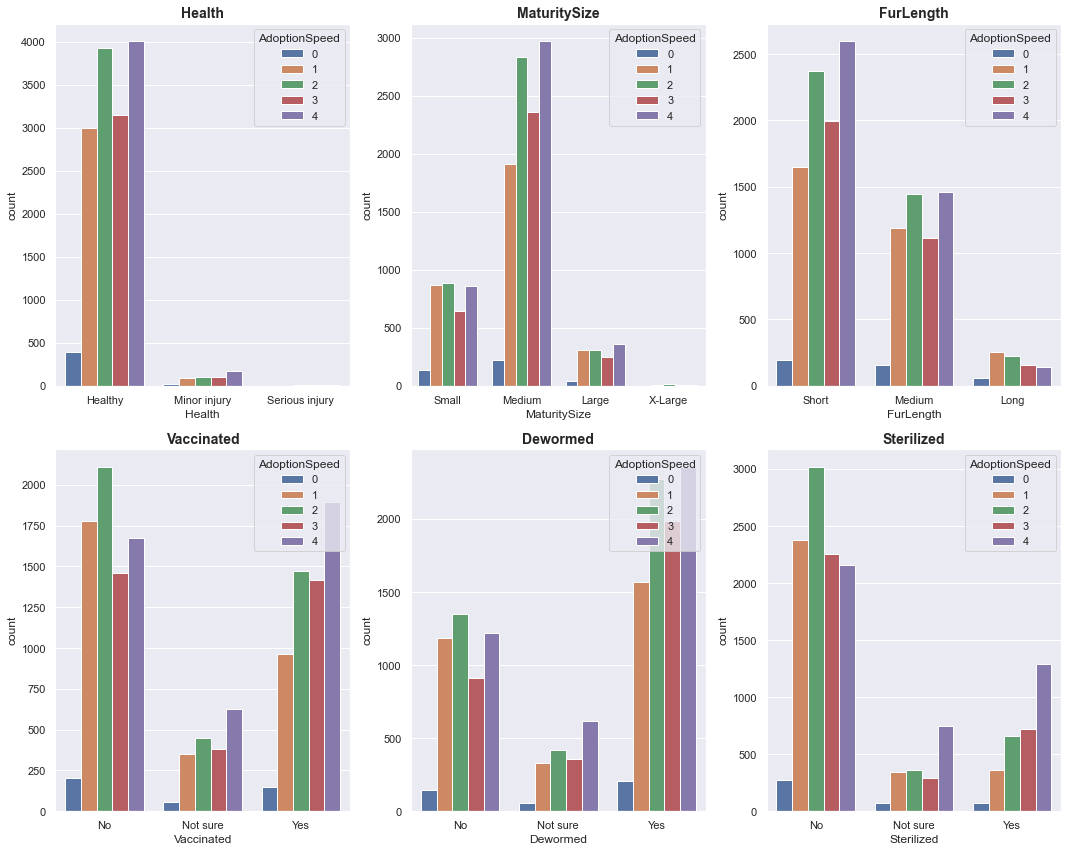

In [8]:
cols = ['Health', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized']
n_rows = 2
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5,n_rows*6))

for r in range(0,n_rows):
    for c in range(0,n_cols):  
        i = r*n_cols+c       
        ax = axs[r][c]
        sns.countplot(df_train[cols[i]], hue=df_train["AdoptionSpeed"], ax=ax)
        ax.set_title(cols[i], fontsize=14, fontweight='bold')
        ax.legend(title="AdoptionSpeed", loc='upper right') 
        
plt.tight_layout() 

* Mostly healthy pets were listed by the shelter.
* Medium sized pets made majority of the listing with a few x-large animals and they are adopted within 30 days of listing. Medium sized animals are taken faster in the first one week and same day
* Short fur length animals are adopted faster.
* Surprisingly, unvaccinated and unsterilized animals are adopted faster within the first 30 days of listing.
* Dewormed animals listed are adopted faster.


#### Age distribution in months 

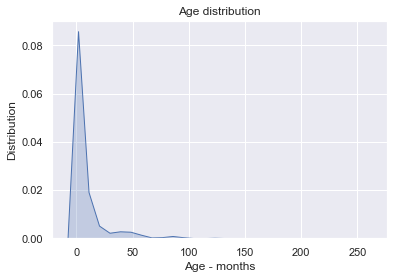

In [9]:
ax = sns.kdeplot(data=df_train['Age'], shade=True, gridsize = 30)
_ = ax.set(title='Age distribution', ylabel='Distribution', xlabel='Age - months')

Most of the animals are within 12 months old.

#### Correlation heatmap

Text(0.5, 1.0, 'AdoptionSpeed')

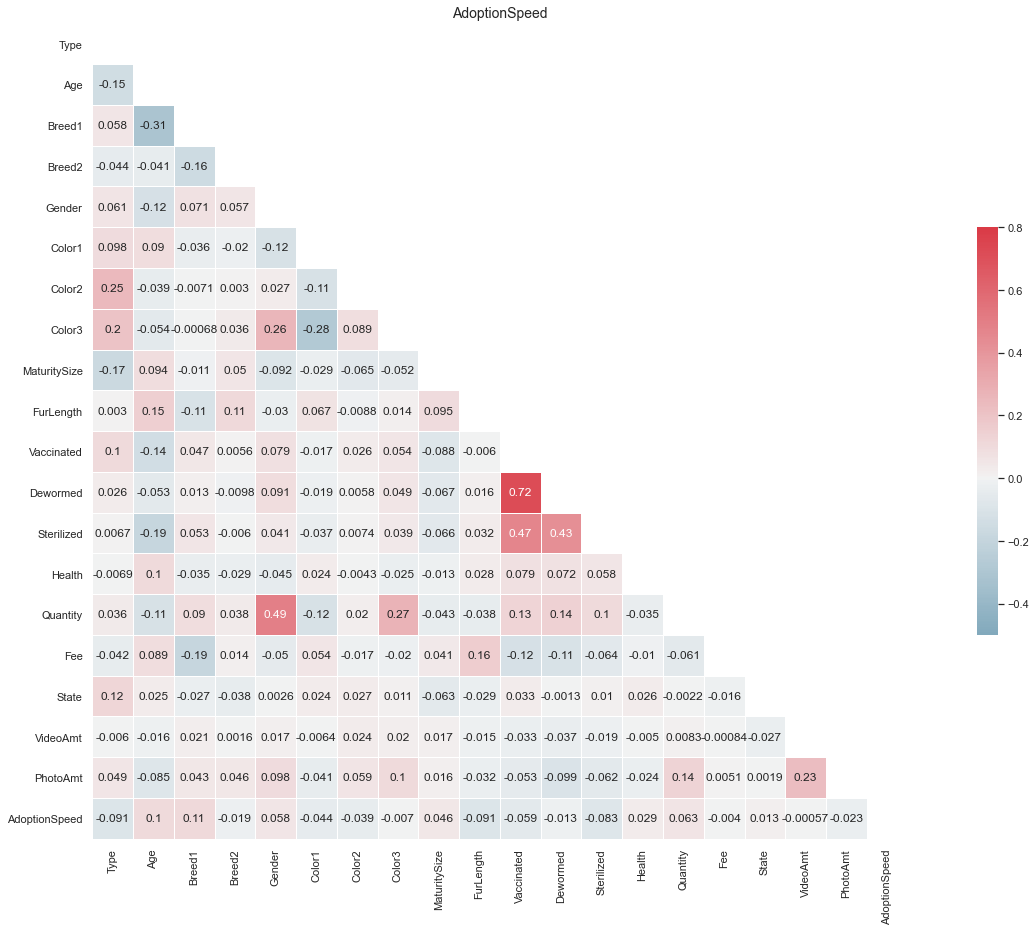

In [63]:
sns.set_theme(style="white")
df_adopt = train.copy()

f, ax = plt.subplots(1,1,figsize=(25,15))
corr = train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 10, as_cmap=True)

ax = sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5,vmax=0.8,vmin=-.5, cbar_kws={"shrink": .5}, annot=True)
ax.set_title("AdoptionSpeed",fontsize=14)

Most of the variables are not correlated to adoption speed. Variables like `Age` and `Breed1` are quite correlated to adoption speed.

## Feature Engineering -  Data Preparation

In [11]:
train_df = df_train.copy()
test_id = test['PetID']
target = train['AdoptionSpeed']

In [12]:
X_train = train_df.drop(['PetID','Name','RescuerID', 'Description','AdoptionSpeed','Color1','Color2','Color3','Breed1','Breed2', 'State'],axis=1)
X_test = test.drop(['PetID','Name','RescuerID', 'Description','Color1','Color2','Color3','Breed1','Breed2', 'State'],axis=1)

In [13]:
# Clean the fee column
X_train.loc[train_df['Fee']>=1, 'Fee']='Paid'
X_train.loc[train_df['Fee']==0, 'Fee']='Free'
X_test.loc[test['Fee']>=1, 'Fee']='Paid'
X_test.loc[test['Fee']==0, 'Fee']='Free'

# Clean the Video column
X_train.loc[train_df['VideoAmt']>=1, 'VideoAmt']='Yes'
X_train.loc[train_df['VideoAmt']==0, 'VideoAmt']='No'
X_test.loc[test['VideoAmt']>=1, 'VideoAmt']='Yes'
X_test.loc[test['VideoAmt']==0, 'VideoAmt']='No'

In [14]:
# List of categorical features
cat_features = list(X_train.select_dtypes(include=['object', 'category']).columns)
print(cat_features)
# List of numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = list(X_train.select_dtypes(include=numeric_dtypes).columns)
print(num_features)

['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Fee', 'VideoAmt']
['Age', 'Quantity', 'PhotoAmt']


#### Encode Categorial Features

In [15]:
from sklearn.preprocessing import LabelEncoder
encoded_features = list()
for df in [X_train,X_test]:
    for feature in cat_features:
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
        
X_train = pd.concat([X_train, *encoded_features[:len(cat_features)]], axis=1)
X_test = pd.concat([X_test, *encoded_features[len(cat_features):]], axis=1)

In [16]:
target.value_counts()

4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64

In [17]:
X_train = X_train.drop(cat_features, axis=1)
X_test = X_test.drop(cat_features, axis=1)

In [18]:
# Smote
sm = SMOTE(random_state = SEED)
X_train_res, y_train_res = sm.fit_resample(X_train, target.ravel())

### Scaling

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for cols in num_features:
    scaler.fit(X_train[cols].values.reshape(-1,1))
    X_train[cols] = scaler.transform(X_train[cols].values.reshape(-1,1))
    X_test[cols] = scaler.transform(X_test[cols].values.reshape(-1,1))


In [20]:
# For Smote analysis
for cols in num_features:
    scaler.fit(X_train_res[cols].values.reshape(-1,1))
    X_train_res[cols] = scaler.transform(X_train_res[cols].values.reshape(-1,1))
    X_test[cols] = scaler.transform(X_test[cols].values.reshape(-1,1))

## Modeling

In [21]:

def quadratic_weighted_kappa(model,actual,predicted):
    return cohen_kappa_score(actual, predicted, weights='quadratic')

kappa_scorer = make_scorer(cohen_kappa_score,weights = "quadratic")

### Logistic Regression - Baseline Model

In [22]:
from sklearn.linear_model import LogisticRegression
df = []
scoring = {"kappa": kappa_scorer}
lr = LogisticRegression()
kfolds = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, shuffle=True, random_state=SEED)
cv_results = cross_validate(lr,X_train,target,cv=kfolds,scoring=scoring,return_train_score=True)
lr_model = lr.fit(X_train,target)
name = 'Logistic Regression'
test_prediction = lr_model.predict(X_test)

In [23]:
#Create a dataframe for result
result_df = pd.DataFrame(cv_results)
result_df['Model'] = name
df.append(result_df)
final_result_df = pd.concat(df, ignore_index=True)
final_result_df.groupby(['Model']).agg({'fit_time':'mean','score_time':'mean', 'test_kappa':'mean', 'train_kappa':'mean'}).reset_index().sort_values(by="test_kappa", ascending = False)

,Model,fit_time,score_time,test_kappa,train_kappa
0,Logistic Regression,0.431386,0.007909,0.216868,0.225479


### Logistic Regression with SMOTE

In [24]:
# Using smote analysis
df_sm = []
lr = LogisticRegression()
kfolds = KFold(n_splits=10, shuffle=True, random_state=SEED)
cv_results_sm = cross_validate(lr,X_train_res,y_train_res,cv=kfolds,scoring=scoring,return_train_score=True)
lr_model_sm = lr.fit(X_train_res,y_train_res)
name_sm = 'Logistic Regression with smote'
test_prediction_sm = lr_model_sm.predict(X_test)

In [25]:
#Create a dataframe for result
result_df_sm = pd.DataFrame(cv_results_sm)
result_df_sm['Model'] = name_sm
df_sm.append(result_df_sm)
final_result_df = pd.concat(df_sm, ignore_index=True)
final_result_df.groupby(['Model']).agg({'fit_time':'mean','score_time':'mean', 'test_kappa':'mean', 'train_kappa':'mean'}).reset_index().sort_values(by="test_kappa", ascending = False)

,Model,fit_time,score_time,test_kappa,train_kappa
0,Logistic Regression with smote,0.658442,0.005841,0.266482,0.272048


### Logistic Regression with Hyperparameter tuning

In [26]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}
]

# Create grid search object
lr_clf = GridSearchCV(pipe, param_grid = param_grid, cv = kfolds, verbose=True, n_jobs=-1)

# Fit on data
best_clf = lr_clf.fit(X_train, target)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [27]:
print(lr_clf.best_params_)
print(lr_clf.best_score_)

{'classifier': LogisticRegression(C=0.012742749857031334, solver='liblinear'), 'classifier__C': 0.012742749857031334, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
0.3564322881921281


In [28]:
df_opt=[]
lr_opt = LogisticRegression(C=0.012742749857031334, solver='liblinear')
cv_results_opt = cross_validate(lr_opt,X_train,target,cv=kfolds,scoring=scoring,return_train_score=True)
lr_model_opt = lr_opt.fit(X_train,target)
name = 'Logistic Regression with optimization'
test_prediction = lr_model_opt.predict(X_test)

In [29]:
  #Create a dataframe for result
result_df_opt = pd.DataFrame(cv_results_opt)
result_df_opt['Model'] = name
df_opt.append(result_df_opt)
final_result_df = pd.concat(df_opt, ignore_index=True)
final_result_df.groupby(['Model']).agg({'fit_time':'mean','score_time':'mean', 'test_kappa':'mean', 'train_kappa':'mean'}).reset_index().sort_values(by="test_kappa", ascending = False)

,Model,fit_time,score_time,test_kappa,train_kappa
0,Logistic Regression with optimization,0.10755,0.004686,0.215599,0.219794


### Other Models without Smote or optimization

In [30]:
df_models = []
def construct_models():
    """Function to create different models"""
    models = dict()
    models['Random_Forest_Classifier'] = RandomForestClassifier()
    models['Decison_tree_Classifier'] = DecisionTreeClassifier()
    models['Gradient_Boost_Classifier'] = GradientBoostingClassifier()
    models['Support_Vector_Classifier'] = SVC()
    return models

models = construct_models()

In [31]:
for name, model in models.items():
    cv_results_models = cross_validate(model,X_train,target,cv=kfolds,scoring=scoring,return_train_score=True)
    #Create a dataframe for result
    result_df_model = pd.DataFrame(cv_results_models)
    result_df_model['Model'] = name
    df_models.append(result_df_model)
    final_result_df = pd.concat(df_models, ignore_index=True)
final_result_df.groupby(['Model']).agg({'fit_time':'mean','score_time':'mean', 'test_kappa':'mean', 'train_kappa':'mean'}).reset_index().sort_values(by="test_kappa", ascending = False)

,Model,fit_time,score_time,test_kappa,train_kappa
1,Gradient_Boost_Classifier,5.361121,0.014189,0.288658,0.322853
3,Support_Vector_Classifier,9.867377,2.455962,0.262833,0.307426
2,Random_Forest_Classifier,0.989544,0.044557,0.234043,0.885568
0,Decison_tree_Classifier,0.069252,0.004594,0.175439,0.884326


### Other Models with Smote

In [32]:
df_models_sm = []
for name, model in models.items():
    cv_results_models_sm = cross_validate(model,X_train_res,y_train_res,cv=kfolds,scoring=scoring,return_train_score=True)
    #Create a dataframe for result
    result_df_model_sm = pd.DataFrame(cv_results_models_sm)
    result_df_model_sm['Model'] = name
    df_models_sm.append(result_df_model_sm)
    final_result_df_sm= pd.concat(df_models_sm, ignore_index=True)
    


In [33]:
final_result_df_sm.groupby(['Model']).agg({'fit_time':'mean', 'score_time':'mean','test_kappa':'mean', 'train_kappa':'mean'}).reset_index().sort_values(by="test_kappa", ascending = False)

,Model,fit_time,score_time,test_kappa,train_kappa
2,Random_Forest_Classifier,1.574584,0.171724,0.590577,0.936679
1,Gradient_Boost_Classifier,9.934138,0.019743,0.574472,0.593991
0,Decison_tree_Classifier,0.117187,0.006063,0.519779,0.934727
3,Support_Vector_Classifier,17.517156,4.593815,0.472571,0.511085


### Other Models with optimization


In [34]:
# Initialze the estimators
clf1 = RandomForestClassifier(random_state=42)
clf2 = SVC(probability=True, random_state=42)
clf3 = DecisionTreeClassifier(random_state=42)
clf4 = GradientBoostingClassifier(random_state=42)

In [35]:
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__max_depth'] = [5,10,25,None]
param3['classifier__min_samples_split'] = [2,5,10]
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__n_estimators'] = [10, 50, 100, 250]
param4['classifier__max_depth'] = [5, 10, 20]
param4['classifier'] = [clf4]

In [36]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2,param3, param4]

In [39]:
# gs = GridSearchCV(pipeline, params, cv=kfolds, n_jobs=-1,verbose=True).fit(X_train, target)

In [40]:

df_gb_opt=[]
gb_opt = GradientBoostingClassifier(max_depth=5, n_estimators=50, random_state=42)
cv_results_gb = cross_validate(gb_opt,X_train,target,cv=kfolds,scoring=scoring,return_train_score=True)
gb_model_opt = gb_opt.fit(X_train,target)
name_gb = 'Gradient Boosting with optimization'
# test_prediction = gb_model_opt.predict(X_test)

In [41]:
#Create a dataframe for result
result_df_gbc = pd.DataFrame(cv_results_gb)
result_df_gbc['Model'] = name_gb
df_gb_opt.append(result_df_gbc)
final_result_df = pd.concat(df_gb_opt, ignore_index=True)
final_result_df.groupby(['Model']).agg({'fit_time':'mean','score_time':'mean', 'test_kappa':'mean', 'train_kappa':'mean'}).reset_index().sort_values(by="test_kappa", ascending = False)

,Model,fit_time,score_time,test_kappa,train_kappa
0,Gradient Boosting with optimization,4.129578,0.013614,0.291255,0.379348


### Feature Importance

In [51]:
feature_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': gb_model_opt.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance[0:10]


,Attribute,Importance
0,Age,0.287236
2,PhotoAmt,0.164727
1,Quantity,0.084257
23,Sterilized_1,0.055117
14,FurLength_1,0.031661
12,MaturitySize_3,0.027405
11,MaturitySize_2,0.026210
25,Sterilized_3,0.026033
5,Type_1,0.023842
6,Type_2,0.021033


In [55]:
important_features = feature_importance[feature_importance['Importance'] > 0.02]['Attribute'].values

In [60]:

df_models_feat_imp = []
for name, model in models.items():
    cv_results_feat_imp = cross_validate(model,X_train[important_features],target,cv=kfolds,scoring=scoring,return_train_score=True)
    #Create a dataframe for result
    result_df_model_feat = pd.DataFrame(cv_results_feat_imp)
    result_df_model_feat['Model'] = name
    df_models_feat_imp.append(result_df_model_feat)
    final_result_df_feat= pd.concat(df_models_feat_imp, ignore_index=True)
final_result_df_feat.groupby(['Model']).agg({'fit_time':'mean','score_time':'mean', 'test_kappa':'mean', 'train_kappa':'mean'}).reset_index().sort_values(by="test_kappa", ascending = False)

,Model,fit_time,score_time,test_kappa,train_kappa
1,Gradient_Boost_Classifier,3.553226,0.012700,0.275903,0.307581
3,Support_Vector_Classifier,8.871637,1.529012,0.252714,0.268233
2,Random_Forest_Classifier,0.707097,0.036516,0.209723,0.598952
0,Decison_tree_Classifier,0.025756,0.002871,0.193416,0.599564


In [ ]:
submission = pd.DataFrame({'PetID': test_id, 'AdoptionSpeed': test_prediction})
submission.to_csv("submission.csv",index=False)

### Results and Conclusion


In [ ]:
x = PrettyTable()
x.field_names = ['Model - Feature Engineered Data','Predict time','Train kappa','Test kappa']
x.add_row(['Logistic Regression - Baseline',0.008181,0.225479,0.216868])
x.add_row(['Logistic Regression with hyperparameter',0.00461,0.215599,0.219794])
x.add_row(['Random Forest Classifier',0.045285,0.235010,0.885404])
x.add_row(['Gradient Boosting Classifier',0.015275,0.288705,0.322853])
x.add_row(['Support Vector Classifier',2.687992,0.262833,0.307426])
x.add_row(['Decision Tree Classifier',0.004784,0.174203,0.884326])
x.add_row(['Gradient Boosting with optimization',0.015462,0.291255,0.379348])
y = PrettyTable()
y.field_names = ['Model - SMOTE ','Predict time','Train kappa','Test kappa']
y.add_row(['Logistic Regression - Baseline',0.005892,0.266482,0.272048])
y.add_row(['Random Forest Classifier',0.056918,0.591774,0.936780])
y.add_row(['Gradient Boosting Classifier',0.021319,0.574000,0.593972])
y.add_row(['Support Vector Classifier',4.810073,0.472571,0.511085])
y.add_row(['Decision Tree Classifier',0.006042,0.520192,0.934727])
print('-- Result 1 --')
print(x)
print('-- Result 2 --')
print(y)

-- Result 1 --
+-----------------------------------------+--------------+-------------+------------+
|     Model - Feature Engineered Data     | Predict time | Train kappa | Test kappa |
+-----------------------------------------+--------------+-------------+------------+
|      Logistic Regression - Baseline     |   0.008181   |   0.225479  |  0.216868  |
| Logistic Regression with hyperparameter |   0.00461    |   0.215599  |  0.219794  |
|         Random Forest Classifier        |   0.045285   |   0.23501   |  0.885404  |
|       Gradient Boosting Classifier      |   0.015275   |   0.288705  |  0.322853  |
|        Support Vector Classifier        |   2.687992   |   0.262833  |  0.307426  |
|         Decision Tree Classifier        |   0.004784   |   0.174203  |  0.884326  |
|   Gradient Boosting with optimization   |   0.015462   |   0.291255  |  0.379348  |
+-----------------------------------------+--------------+-------------+------------+
-- Result 2 --
+-----------------------

The shortest predict time was achieved with Logistic Regression with hyperparameter tuning, while Gradient Boost Classifier using smote sampling had a good score on test and train kappa but performed poorly on the leaderboard.

The Gradient Boost Classifier without hyperparameters performed best on the leader board achieving a score of `0.23040`.  The baseline Logistic Regression model had a score of `0.18179`.

Overfitting was observed for Random Forest and Decision Tree classifier with and without optimization. Reducing the number of features addressed the overfitting slightly for the 2 models.